# Sprint 機械学習スクラッチ　決定木

In [1]:
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import scipy.stats as stats

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier

from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

In [2]:
def decision_region(X_train, y_train, model, step=0.01, title='decision region', 
                    xlabel='xlabel', ylabel='ylabel', target_names=['versicolor', 'virginica']):
    """
    2値分類を2次元の特徴量で学習したモデルの決定領域を描く。
    背景の色が学習したモデルによる推定値から描画される。
    散布図の点は学習用データである。

    Parameters
    ----------------
    X_train : ndarray, shape(n_samples, 2)
        学習用データの特徴量
    y_train : ndarray, shape(n_samples,)
        学習用データの正解値
    model : object
        学習したモデルのインスンタスを入れる
    step : float, (default : 0.1)
        推定値を計算する間隔を設定する
    title : str
        グラフのタイトルの文章を与える
    xlabel, ylabel : str
        軸ラベルの文章を与える
    target_names= : list of str
        凡例の一覧を与える
    """
    # setting
    scatter_color = ['red', 'blue']
    contourf_color = ['pink', 'skyblue']
    n_class = 2

    # pred
    mesh_f0, mesh_f1  = np.meshgrid(np.arange(np.min(X_train[:,0])-0.5, np.max(X_train[:,0])+0.5, step), 
                                    np.arange(np.min(X_train[:,1])-0.5, np.max(X_train[:,1])+0.5, step))
    mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]
    pred = model.predict(mesh).reshape(mesh_f0.shape)

    # plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.contourf(mesh_f0, mesh_f1, pred, n_class-1, cmap=ListedColormap(contourf_color))
    plt.contour(mesh_f0, mesh_f1, pred, n_class-1, colors='y', linewidths=3, alpha=0.5)
    for i, target in enumerate(set(y_train)):
        plt.scatter(X_train[y_train==target][:, 0], X_train[y_train==target][:, 1], s=80, color=scatter_color[i],
                    label=target_names[i], marker='o')
    patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i]) for i in range(n_class)]
    plt.legend(handles=patches)
    plt.legend()
    plt.show()

In [3]:
class ScratchDecesionTreeClassifierDepth1():
    """
    深さ1の決定木分類器のスクラッチ実装

    Parameters
    ----------
    verbose : bool
      学習過程を出力する場合はTrue
    """

    def __init__(self, verbose=False):
        # ハイパーパラメータを属性として記録
        self.verbose = verbose
        
    def _gini(self, y):
        score = 0
        classes = np.unique(y)
        n_samples = len(y)
        for col in classes:
            p = np.sum(col == y)
            score += p**2
        try :
            I = 1-( score / ((n_samples)**2))
            return I
        except ZeroDivisionError:
            I = 0
            return I
        
    def _Information_gain(self, X, y,  left_x, left_y, right_x, right_y):
        IG = self._gini(y) - (len(left_x) / len(X))* self._gini(left_y) - (len(right_x) / len(X)) * self._gini(right_y)
        return IG
        
    def _search_split(self, X, y):
        self.history =[]
        self.split_point = 0
        for i in range(X.shape[1]):
            for j in range(X.shape[0]):
                left_X, right_X = X[X[:, i] >= X[j, i]],  X[X[:, i] < X[j, i]]
                left_y, right_y = y[X[:, i] >= X[j, i]],   y[X[:, i] < X[j, i]]
                gain = self._Information_gain(X, y, left_X, left_y, right_X, right_y)
                if gain >= self.split_point:
                    self.split_point = gain
                    self.threshold = X[j, i]
                    self.column = i
                    self.left_class = np.argmax(np.bincount(left_y))
                    self.right_class = np.argmax(np.bincount(right_y))
                    
                    self.history.append(gain)
                
 

    def fit(self, X, y):
        """
        決定木分類器を学習する
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            学習用データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            学習用データの正解値
        """
        self._search_split(X, y)

        if self.verbose:
            #verboseをTrueにした際は学習過程を出力
            print(self.history)

    def predict(self, X):
        """
        決定木分類器を使いラベルを推定する
        """
        
        result_list = []
        for m in X[:, self.column]:
            if m >= self.threshold:
                result_list.append(self.left_class)
            else:
                result_list.append(self.right_class)
                
        return np.array(result_list)

#### シンプルデータセット2

In [4]:
X = np.array([[-0.44699 , -2.8073  ],[-1.4621  , -2.4586  ],
       [ 0.10645 ,  1.9242  ],[-3.5944  , -4.0112  ],
       [-0.9888  ,  4.5718  ],[-3.1625  , -3.9606  ],
       [ 0.56421 ,  0.72888 ],[-0.60216 ,  8.4636  ],
       [-0.61251 , -0.75345 ],[-0.73535 , -2.2718  ],
       [-0.80647 , -2.2135  ],[ 0.86291 ,  2.3946  ],
       [-3.1108  ,  0.15394 ],[-2.9362  ,  2.5462  ],
       [-0.57242 , -2.9915  ],[ 1.4771  ,  3.4896  ],
       [ 0.58619 ,  0.37158 ],[ 0.6017  ,  4.3439  ],
       [-2.1086  ,  8.3428  ],[-4.1013  , -4.353   ],
       [-1.9948  , -1.3927  ],[ 0.35084 , -0.031994],
       [ 0.96765 ,  7.8929  ],[-1.281   , 15.6824  ],
       [ 0.96765 , 10.083   ],[ 1.3763  ,  1.3347  ],
       [-2.234   , -2.5323  ],[-2.9452  , -1.8219  ],
       [ 0.14654 , -0.28733 ],[ 0.5461  ,  5.8245  ],
       [-0.65259 ,  9.3444  ],[ 0.59912 ,  5.3524  ],
       [ 0.50214 , -0.31818 ],[-3.0603  , -3.6461  ],
       [-6.6797  ,  0.67661 ],[-2.353   , -0.72261 ],
       [ 1.1319  ,  2.4023  ],[-0.12243 ,  9.0162  ],
       [-2.5677  , 13.1779  ],[ 0.057313,  5.4681  ]])
y = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

#### 学習と推定

In [6]:
scratched_detection_tree = ScratchDecesionTreeClassifierDepth1()
scratched_detection_tree.fit(X_train, y_train)
y_pred = scratched_detection_tree.predict(X_test)
print("accuracy:", accuracy_score(y_test, y_pred))
print("precision:", precision_score(y_test, y_pred))
print("recall:", recall_score(y_test, y_pred))
print("f1:",f1_score(y_test, y_pred) )
print("matrix\n", confusion_matrix(y_test, y_pred))

accuracy: 0.5
precision: 0.6666666666666666
recall: 0.2857142857142857
f1: 0.4
matrix
 [[4 1]
 [5 2]]


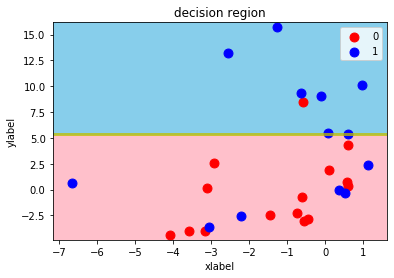

In [7]:
decision_region(X_train, y_train, scratched_detection_tree, target_names=["0", "1"])


#### sklearn

accuracy: 0.5
precision: 0.6666666666666666
recall: 0.2857142857142857
f1: 0.4
matrix
 [[4 1]
 [5 2]]


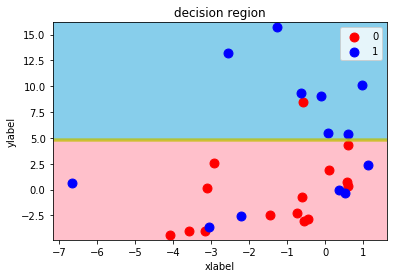

In [8]:
skl_Dtree = DecisionTreeClassifier(max_depth=1)
skl_Dtree.fit(X_train, y_train)
y_pred_skl = skl_Dtree.predict(X_test)
print("accuracy:", accuracy_score(y_test, y_pred_skl))
print("precision:", precision_score(y_test, y_pred_skl))
print("recall:", recall_score(y_test, y_pred_skl))
print("f1:",f1_score(y_test, y_pred_skl))
print("matrix\n", confusion_matrix(y_test, y_pred_skl))
decision_region(X_train, y_train, skl_Dtree, target_names=["0", "1"])
